In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import os

sns.set_theme()

In [3]:
def plotData(file, nIter, title, colsToUse):
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    dataMaxMeans, dataMeanMeans = buildData(file, nIter, colsToUse)
    xTicks = [2**i for i in range(len(dataMaxMeans))]
    ax1.plot(xTicks, dataMaxMeans, label=dataMaxMeans.columns)
    buildAx(title + " - Max time", xTicks, ax1)
    ax2.plot(xTicks, dataMeanMeans, label=dataMeanMeans.columns)
    buildAx(title + " - Mean time", xTicks, ax2)

def plotDataStack(file, nIter, title, colsToUse):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    dataMaxMeans, dataMeanMeans = buildData(file, nIter, colsToUse)
    xTicks = [2**i for i in range(len(dataMaxMeans))]
    ax1.stackplot(xTicks, dataMaxMeans.T, labels=dataMaxMeans.columns)
    buildAx(title + " - Max time", xTicks, ax1)
    ax2.stackplot(xTicks, dataMeanMeans.T, labels=dataMeanMeans.columns)
    buildAx(title + " - Mean time", xTicks, ax2)
    
def plotDataStackBar(file, nIter, title, colsToUse):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    dataMaxMeans, dataMeanMeans = buildData(file, nIter, colsToUse)
    xTicks = [2**i for i in range(len(dataMaxMeans))] 
    for col in dataMaxMeans.columns:
        ax1.bar(xTicks, dataMaxMeans[col], label=col)
        ax2.bar(xTicks, dataMeanMeans[col], label=col)
    buildAx(title + " - Max time", xTicks, ax1)
    buildAx(title + " - Mean time", xTicks, ax2)
   
    
def buildData(file, nIter, colsToUse):
    data = pd.read_csv(file,header=0,sep=";")
    dataMax = data[::2]
    dataMean = data[1::2]
    dataMaxMeans = pd.DataFrame([dataMax[i:i+nIter].mean() for i in range(0, len(dataMax), nIter)])
    dataMeanMeans = pd.DataFrame([dataMean[i:i+nIter].mean() for i in range(0, len(dataMean), nIter)])
    dataMaxMeans = dataMaxMeans[colsToUse]
    dataMaxMeans = dataMaxMeans.reindex(dataMaxMeans.mean().sort_values(ascending=False).index, axis=1)
    dataMeanMeans = dataMeanMeans[colsToUse]
    dataMeanMeans = dataMeanMeans.reindex(dataMeanMeans.mean().sort_values(ascending=False).index, axis=1)
    return dataMaxMeans, dataMeanMeans
        
def buildAx(title, xTicks, ax):
    xLabels = [str(i) for i in xTicks]
    ax.set_xscale("log", base=2)
    ax.set_xticks(xTicks, xLabels)
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    ax.legend()
    ax.plot()

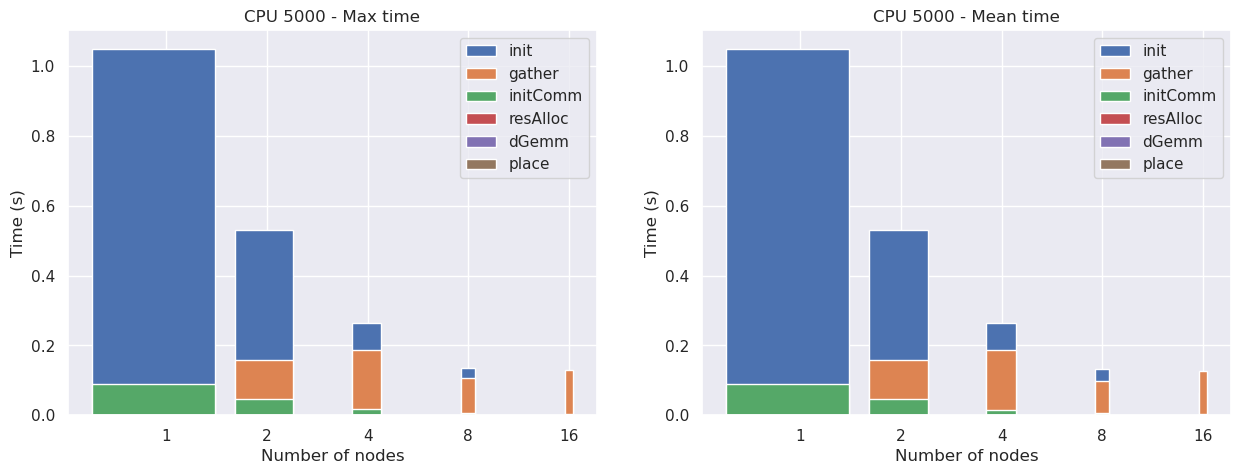

In [13]:
# "init", "initComm", "gather", "resAlloc", "dGemm", "place", "mult", "total"
colsToUse = ["init", "initComm", "gather", "resAlloc", "dGemm", "place"]
plotDataStackBar("basic5000.csv",5,"CPU 5000", colsToUse)